In [13]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import os
import keras_tuner as kt

from tensorflow.keras import layers, Model, optimizers, losses, callbacks
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split, GridSearchCV
from keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier

In [14]:
train = pd.read_csv('../data/preprocessed/train_data.csv')
test = pd.read_csv('../data/preprocessed/test_data.csv')
val = pd.read_csv('../data/preprocessed/val_data.csv')

In [15]:
X_train = train.drop("Is high risk", axis=1)
Y_train = train["Is high risk"]

X_test = test.drop("Is high risk", axis=1)
Y_test = test["Is high risk"]

X_val = val.drop("Is high risk", axis=1)
Y_val = val["Is high risk"]

In [16]:
def model_builder(hp):
  x = layers.Input(shape=(X_train.shape[1],))
  h = layers.Dense(64, activation='relu')(x)
  h = layers.Dense(64, activation='relu')(h)
  h = layers.Dense(64, activation='relu')(h)
  h = layers.Dense(64, activation='relu')(h)

  y = layers.Dense(1, activation='sigmoid')(h)

  model = Model(inputs=x, outputs=y)

  # Tune the learning rate for the optimizer
  # Choose an optimal value 
  # hp_learning_rate = hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001, 0.00001, 0.000001, 0.0000001, 0.00000001])

  hp_batch_size = hp.Choice('batch_size', values=[32, 64, 128, 256, 512])
  
  optimizer = optimizers.Adam(learning_rate=0.001, 
                            beta_1=0.9, 
                            beta_2=0.999, 
                            amsgrad=True)

  model.compile(optimizer=optimizer,
                loss=losses.BinaryCrossentropy(from_logits=False),
                metrics=['accuracy'])

  return model

In [17]:
#delete Folder optimization if it exists
if os.path.exists('optimization'):
    os.system('rm -rf optimization')

In [18]:
tuner = kt.RandomSearch(model_builder,
                     objective='val_accuracy',
                     max_trials=20,
                     executions_per_trial=1,
                     directory='optimization',
                     project_name='ml',
                     overwrite=True)

In [19]:
def run_tuning(tuner, X_train, Y_train, X_val, Y_val):
    tuner.search(X_train, Y_train, 
                 epochs=10, 
                 validation_data=(X_val, Y_val),
                #  callbacks=[]
                 )

    # Get the optimal hyperparameters
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    optimal_batch_size = best_hps.get('batch_size')

    print(f"""
    The hyperparameter search is complete. The optimal batch size is {optimal_batch_size}.
    """)

    return best_hps

In [20]:
best_hps = run_tuning(tuner, X_train, Y_train, X_val, Y_val)

Trial 5 Complete [00h 00m 13s]
val_accuracy: 0.5591517686843872

Best val_accuracy So Far: 0.5695684552192688
Total elapsed time: 00h 01m 06s

    The hyperparameter search is complete. The optimal batch size is 32.
    


In [21]:
model = tuner.hypermodel.build(best_hps)
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 47)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,617 (61.00 KB)

 Trainable params: 15,617 (61.00 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    min_delta=0.001,     # Minimum change to qualify as an improvement
    patience=10,         # How many epochs to wait after last time val loss improved
    verbose=1,
    mode='min',          # The training will stop when the quantity monitored has stopped decreasing
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored quantity.
)

In [23]:
batch_size = best_hps.get('batch_size')
epochs = 1000

history = model.fit(X_train, 
                    Y_train, 
                    batch_size=batch_size,
                    validation_data=(X_val, Y_val),
                    callbacks=[early_stopping],
                    epochs=epochs)

Epoch 1/1000
1568/1568 ━━━━━━━━━━━━━━━━━━━━ 2s 811us/step - accuracy: 0.5092 - loss: 180.6653 - val_accuracy: 0.4995 - val_loss: 30.5430
Epoch 2/1000
1568/1568 ━━━━━━━━━━━━━━━━━━━━ 1s 764us/step - accuracy: 0.5175 - loss: 17.2313 - val_accuracy: 0.5004 - val_loss: 14.8626
Epoch 3/1000
1568/1568 ━━━━━━━━━━━━━━━━━━━━ 1s 845us/step - accuracy: 0.5283 - loss: 5.8521 - val_accuracy: 0.5208 - val_loss: 1.8759
Epoch 4/1000
1568/1568 ━━━━━━━━━━━━━━━━━━━━ 1s 803us/step - accuracy: 0.5432 - loss: 2.4501 - val_accuracy: 0.5166 - val_loss: 2.1074
Epoch 5/1000
1568/1568 ━━━━━━━━━━━━━━━━━━━━ 1s 829us/step - accuracy: 0.5432 - loss: 2.1631 - val_accuracy: 0.4990 - val_loss: 2.4789
Epoch 6/1000
1568/1568 ━━━━━━━━━━━━━━━━━━━━ 1s 746us/step - accuracy: 0.5575 - loss: 1.5670 - val_accuracy: 0.5119 - val_loss: 1.2301
Epoch 7/1000
1568/1568 ━━━━━━━━━━━━━━━━━━━━ 1s 802us/step - accuracy: 0.5547 - loss: 1.3163 - val_accuracy: 0.5770 - val_loss: 0.8920
Epoch 8/1000
1568/1568 ━━━━━━━━━━━━━━━━━━━━ 1s 723us/step

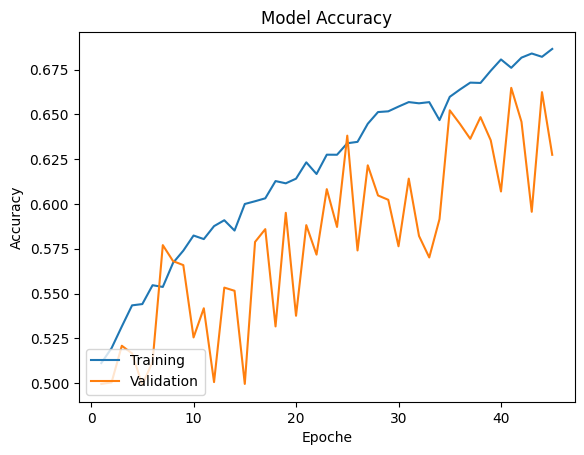

In [24]:
# Print the model training history for accuracy
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy)
plt.plot(epochs, val_accuracy)
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoche')
plt.legend(['Training', 'Validation'], loc='lower left')
# plt.xticks(np.arange(1, len(accuracy)+1, 1))
plt.show()

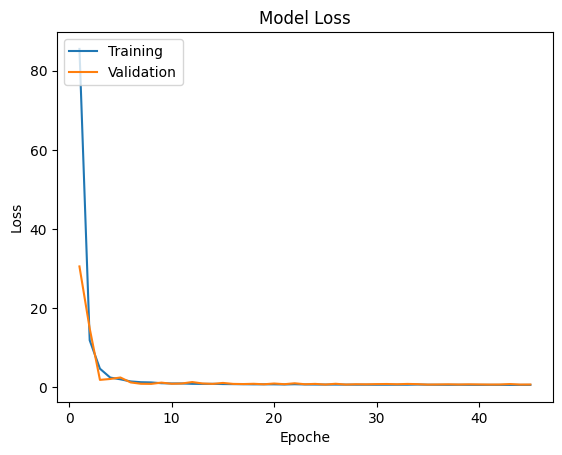

In [25]:
# print the model training history for loss
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoche')
plt.legend(['Training', 'Validation'], loc='upper left')
# plt.xticks(np.arange(1, len(loss)+1, 1))
plt.show()

In [26]:
model.evaluate(X_test, Y_test)

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step - accuracy: 0.5323 - loss: 0.7699


[0.7715675830841064, 0.531358540058136]

In [27]:
model.evaluate(X_val, Y_val)

336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step - accuracy: 0.5680 - loss: 0.7456


[0.6918534636497498, 0.6522507667541504]

In [28]:
model.evaluate(X_train, Y_train)

1568/1568 ━━━━━━━━━━━━━━━━━━━━ 1s 358us/step - accuracy: 0.5848 - loss: 0.7114


[0.582917332649231, 0.7106385231018066]